## Exploring Malaria Simulation Output Data

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob

# Some base data
strategies = ['status_quo',
              'AL5',
              'AL4',
              'ASAQ',
              'ASAQ25-DHA-PPQ75',
              'AL75-ASAQ25',
              'AL25-DHA-PPQ75',
              'AL25-ASAQ75',
              'ASAQ50-DHA-PPQ50',
              'AL50-DHA-PPQ50',
              'DHA-PPQ',
              'AL75-DHA-PPQ25']

table_names = ['monthlydata', 'sqlite_sequence', 'monthlysitedata', 'genotype', 'monthlygenomedata']

# Database tools -----------------------------------------------------------------------------
def get_all_tables(db: str) -> list:
    """
    Get all tables in a sqlite3 database

    Args:
    db (str): path to sqlite3 database

    Returns:
    list: list of tables in the database
    """
    # Validate input file path
    if not os.path.exists(db):
        raise FileNotFoundError(f"File not found: {db}")
    with sqlite3.connect(db) as conn:
        c = conn.cursor()
        c.execute("SELECT name FROM sqlite_master WHERE type='table';")
        tables = c.fetchall()
    
    return [table[0] for table in tables]

def get_table(db: str, table: str) -> pd.DataFrame:
    """
    Get a table from a sqlite3 database

    Args:
    db (str): path to sqlite3 database
    table (str): name of table to get

    Returns:
    pd.DataFrame: table as a pandas DataFrame
    """
    # Validate input file path
    if not os.path.exists(db):
        raise FileNotFoundError(f"File not found: {db}")
    with sqlite3.connect(db) as conn:
        df = pd.read_sql_query(f"SELECT * FROM {table}", conn)
    
    return df

# Data analysis tools -----------------------------------------------------------------------
def calculate_treatment_failure_rate(data: pd.DataFrame, locationid: int = 0) -> pd.DataFrame:
    """
    Calculate treatment failures for a given table

    Args:
    data (DataFrame): monthlysitedata table to calculate treatment failures
    locationid (int): locationid to filter by

    Returns:
    pd.DataFrame: table with treatment failures
    """
    # Calculate treatment failures
    if locationid > 0:
        data = data[data["locationid"] == locationid]
    data['failure_rate'] = data['treatmentfailures'] / data['treatments']

    return data

def aggregate_monthlysitedata(path: str, strategy: str, locationid: int = 0) -> pd.DataFrame:
    """
    Aggregate data by strategy. This function searchs path for all the result files for the given strategy and aggregates them.

    Args:
    path (str): path to search for result files
    strategy (str): strategy to aggregate data for

    Returns:
    pd.DataFrame: aggregated data
    pd.Series: monthlydataid column
    """
    # Get all files for the strategy
    files = glob.glob(os.path.join(f"{path}", f"*_{strategy}_*.db"))
    if len(files) == 0:
        print(f"No files found for strategy {strategy} in {path}")
        return
    else:
        print(f"Aggregating data for strategy {strategy} with {len(files)} files")
    # Get the monthlysitedata table for the first file to set up aggregated data
    monthlysitedata_columns = get_table(files[0], 'monthlysitedata').columns.to_list()
    monthlysitedata_columns.remove('monthlydataid')
    monthlysitedata_columns.append('failure_rate')
    monthlysitedata = {column : pd.DataFrame() for column in monthlysitedata_columns}    
    # Aggregate data for the rest of the files
    for file in files:
        # print(f"Aggregating data for {file}")
        data = get_table(file, 'monthlysitedata')
        if locationid > 0:
            data = data[data["locationid"] == locationid]
        if 'failure_rate' not in data.columns:
            data = calculate_treatment_failure_rate(data)
        monthlydataid = data['monthlydataid']
        for column in monthlysitedata_columns:            
            if column != 'monthlydataid':                
                monthlysitedata[column] = pd.concat([monthlysitedata[column], data[column]], axis=1)
    # Calculate statistics for the aggregated data
    for column in monthlysitedata_columns:
        if column != 'monthlydataid':
            monthlysitedata[column]['mean'] = monthlysitedata[column].mean(axis=1)
            monthlysitedata[column]['median'] = monthlysitedata[column].median(axis=1)
            monthlysitedata[column]['95th'] = monthlysitedata[column].quantile(axis=1, q=0.95)
            monthlysitedata[column]['5th'] = monthlysitedata[column].quantile(axis=1, q=0.05)           
            
    return monthlysitedata, monthlydataid

def save_aggregated_data(monthlysitedata: dict[str, pd.DataFrame], monthlydataid: pd.Series, strategy: str, path: str):
    """
    Save aggregated data to a file

    Args:
    monthlysitedata (dict[str, pd.DataFrame]): aggregated data
    monthlydataid (pd.Series): monthlydataid column
    strategy (str): strategy
    path (str): path to save the file
    """
    with sqlite3.connect(os.path.join(path, f"{strategy}_aggregated.db")) as conn:
        for column in monthlysitedata.keys():
            monthlysitedata[column].to_sql(column, conn, index=False)
        monthlydataid.to_sql('monthlydataid', conn, index=False)

def plot_strategy_treatment_failure(data: pd.DataFrame, months: pd.DataFrame, strategy: str, figsize: tuple = (18, 3)):
    """
    Plot treatment failure rate for a given strategy

    Args:
        data (pd.DataFrame): treatement failure data to plot
        months (pd.DataFrame): months for the data
        strategy (str): strategy to plot
        figsize (tuple): figure size
    
    Returns:    
        tuple: figure and axis
    """
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(months / 12, data['failure_rate']['mean'], label='Mean')
    ax.fill_between(months / 12, data['failure_rate']['5th'], data['failure_rate']['95th'], color='b', alpha=0.15, label='5th-95th percentile')
    ax.axhline(y=0.1, color='r', linestyle='--', label='10% threshold')
    ax.set_title(f"{strategy} Treatment Failure Rate")
    ax.set_xlabel("Years")
    ax.set_ylabel("Treatment Failure Rate")
    ax.legend()
    return fig, ax

def aggregate_treatment_failures_for_strategies(path: str, strategies: list[str], locationid: int = 0) -> dict[str, pd.DataFrame]:
    """
    Aggregate treatment failures for all strategies

    Args:
    path (str): path to search for result files
    strategies (list): list of strategies to aggregate data for

    Returns:
    dict: dictionary of aggregated dataframes
    """
    aggregated_data = {}
    for strategy in strategies:
        print(f"Aggregating data for {strategy}")
        try:
            data, months = aggregate_monthlysitedata(path, strategy, locationid)
        except TypeError as e:
            print(e)
            continue
        except FileNotFoundError as e:
            print(e)
            continue
        try:
            months = months.to_numpy()
            aggregated_strategy_data = pd.DataFrame.from_dict({
                'months': months,
                'mean': data['failure_rate']['mean'],
                'median': data['failure_rate']['median'],
                '5th': data['failure_rate']['5th'],
                '95th': data['failure_rate']['95th']
            })
        except KeyError as e:
            print(e)
            continue
        except ValueError as e:
            print(e)
            continue
        aggregated_strategy_data.index = aggregated_strategy_data['months']
        aggregated_data[strategy] = aggregated_strategy_data
    return aggregated_data

def get_population_data(file: str, month: int = -1) -> pd.DataFrame:
    """
    Get the population data for a given file and month

    Args:
    file (str): path to sqlite3 database
    month (int): month to filter by, defaults to -1 which returns the last month

    Returns:
    pd.DataFrame: population data
    """
    # Assert the file exists
    if not os.path.exists(file):
        raise FileNotFoundError(f"File not found: {file}")
    population_data = get_table(file, 'monthlysitedata')
    if month > 0:
        population_data = population_data.loc[population_data['monthlydataid'] == month]
    else:
        last_month = population_data.iloc[-1]['monthlydataid']
        population_data = population_data.loc[population_data['monthlydataid'] == last_month]
    population_data = population_data[['locationid', 'population']]
    population_data.index = population_data['locationid']
    population_data = population_data.drop(columns='locationid')
    return population_data

def get_genome_data(file: str, month: int = -1) -> pd.DataFrame:
    """
    Get the genome data for a given file and month

    Args:
    file (str): path to sqlite3 database
    month (int): month to filter by, defaults to -1 which returns the last month

    Returns:
    pd.DataFrame: genome data
    """
    # Assert the file exists
    if not os.path.exists(file):
        raise FileNotFoundError(f"File not found: {file}")
    genome_data = get_table(file, 'monthlygenomedata')
    if month > 0:
        genome_data = genome_data.loc[genome_data['monthlydataid'] == month]
    else:
        last_month = genome_data.iloc[-1]['monthlydataid']
        genome_data = genome_data.loc[genome_data['monthlydataid'] == last_month]
    genome_data = genome_data[['locationid', 'genomeid', 'occurrences']]
    genome_data.index = genome_data['locationid']
    genome_data = genome_data.drop(columns='locationid')
    return genome_data

def calculate_genome_frequencies(file: str, month: int = -1) -> pd.DataFrame:
    """
    Calculate the genome frequencies

    Args:
    file (str): path to sqlite3 database
    month (int): month to filter by, defaults to -1 which returns the last month

    Returns:
    pd.DataFrame: genome frequency data
    """
    # Assert the file exists
    if not os.path.exists(file):
        raise FileNotFoundError(f"File not found: {file}")
    # Get the genomes
    genomes = get_table(file, 'genotype')
    # Get the genome data
    genome_data = get_genome_data(file, month)
    # Get the population data
    population_data = get_population_data(file, month)
    # Calculate the genome frequencies
    genome_frequencies = pd.DataFrame(index=population_data.index, columns=genomes['id'].to_list())
    totals = []
    for genome in genomes['id'].to_list():
        occurrences = genome_data.loc[genome_data['genomeid'] == genome, ['occurrences']]
        occurrences = occurrences.join(population_data, how='outer').fillna(0)
        genome_frequencies[genome] = occurrences['occurrences'] / occurrences['population']
        totals.append(occurrences['occurrences'].sum() / occurrences['population'].sum())
    genome_frequencies.loc['totals'] = totals
    return genome_frequencies

def get_resistant_genotypes(genomes: pd.DataFrame, allele: str) -> pd.DataFrame:
    """
    Get the genotypes that are resistant to an arbitrary drug by selecting
    genotypes that contain the allele that confers resistance.

    Args:
    genomes (pd.DataFrame): genotype data
    allele (str): allele to filter by

    Returns:
    pd.DataFrame: resistant genotypes
    """
    resistant_genotypes = genomes.loc[genomes['name'].str.contains(allele)]
    return resistant_genotypes

def calculate_resistant_genome_frequencies(file: str, allele: str, month: int = -1) -> float:
    """
    Calculate the frequency or prevelance of drug resistant genotypes based on the presence of an allele that confers resistance.

    Args:
    file (str): path to sqlite3 database
    allele (str): allele to filter by, defaults to 'H'
    month (int): month to filter by, defaults to -1 which returns the last month
    
    Returns:
    float: resistant genome prevelance
    """
    # Assert the file exists
    if not os.path.exists(file):
        raise FileNotFoundError(f"File not found: {file}")
    # Get the genomes
    genomes = get_table(file, 'genotype')
    # Get the genome data
    genome_data = get_genome_data(file, month)
    parasite_population = genome_data['occurrences'].sum()
    # Get the resistant genotypes
    resistant_genotypes = get_resistant_genotypes(genomes, allele)
    # Calculate the resistant genome frequencies
    resistant_genome_data = genome_data[genome_data['genomeid'].isin(resistant_genotypes['id'])]
    return resistant_genome_data['occurrences'].sum() / parasite_population


def aggregate_resistant_genome_frequencies(path: str, strategy: str, allele: str = 'H') -> pd.DataFrame:
    """
    Aggregate genome frequencies for a given strategy

    Args:
    path (str): path to search for result files
    strategy (str): strategy to aggregate data for
    locationid (int): locationid to filter by

    Returns:
    pd.DataFrame: aggregated genome frequencies
    """
    # Get all files for the strategy
    files = glob.glob(os.path.join(f"{path}", f"*_{strategy}_*.db"))
    if len(files) == 0:
        print(f"No files found for strategy {strategy} in {path}")
        return
    else:
        print(f"Aggregating data for strategy {strategy} with {len(files)} files")
    # Get the monthlysitedata table for the first file to set up aggregated data
    genome_frequencies = [] #pd.DataFrame() 
    # Aggregate data for the rest of the files
    for file in files:
        print(f"Aggregating data for {file}")
        #data = calculate_genome_frequencies(file)
        genome_frequencies.append(calculate_resistant_genome_frequencies(file, allele))
    
    return genome_frequencies

def plot_strategy_results(path: str, strategy: str, locationid:int = 0) -> plt.Figure:
    """
    Plots the treatment failure rate for a given strategy. If locationid is provided, only that location is plotted.
    If more than one results file is found in the path, the data is aggregated.

    Args:
    path (str): path to directory containing results files
    strategy (str): strategy to plot
    locationid (int): locationid to filter by

    Returns:
    plt.Figure: matplotlib figure
    """
    # Assert that the location is valid
    if locationid < 0:
        raise ValueError("locationid must be a positive integer")
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}")
    # Get all results files in the path
    results_files = glob.glob(os.path.join(path, f"*_{strategy}_.db"))
    if len(results_files) == 0:
        raise FileNotFoundError(f"No results files found for strategy {strategy}")
    # Read all results files
    failures = pd.DataFrame()
    for file in results_files:
        data = get_table(file, 'monthlysitedata')
        data = calculate_treatment_failure_rate(data, locationid)
        failures[file] = data['failure_rate']
        
    if locationid > 0:
        failures = failures.loc[failures['locationid'] == locationid]
    # else, aggregate all locations by taking the mean of the failure rates at each month
    else:
        months = failures['monthlydataid'].unique()
        monthly_average = pd.DataFrame()
        for month in months:
            monthly_data = failures.loc[failures['monthlydataid'] == month]
            monthly_average[month, 'population'] = monthly_data['population'].sum()
            monthly_average[month, 'treatments'] = monthly_data['treatments'].sum()
            monthly_average[month, 'treatmentfailures'] = monthly_data['treatmentfailures'].sum()
            monthly_average[month, 'failure_rate'] = monthly_data['failure_rate'].mean()

    failures['mean'] = failures.mean(axis=1)
    fig, ax = plt.subplots()
    ax.plot(failures['monthlydataid'])

In [2]:
#DATA_ROOT: str = os.path.join("G:\\", "My Drive")
DATA_ROOT: str = os.path.join("/", "home", "james")
DATA_SOURCE: str = os.path.join(DATA_ROOT, "Desktop", "output_old")
filelist = glob.glob(os.path.join(DATA_SOURCE, "*.db"))

In [3]:
filelist[0]

'/home/james/Desktop/output_old/rwanda_AL5_4_monthly_data_0.db'

In [4]:
calculate_resistant_genome_frequencies(filelist[0], 'H')

np.float64(0.6411388431049369)

Aggregating data for strategy status_quo with 11 files
Aggregating data for strategy AL5 with 10 files
No files found for strategy AL4 in /home/james/Desktop/output_old
cannot unpack non-iterable NoneType object
Aggregating data for strategy ASAQ with 5 files
x and y must have same first dimension, but have shapes (0,) and (2,)
Aggregating data for strategy ASAQ25-DHA-PPQ75 with 11 files
Aggregating data for strategy AL75-ASAQ25 with 6 files
Aggregating data for strategy AL25-DHA-PPQ75 with 11 files
Aggregating data for strategy AL25-ASAQ75 with 3 files
Aggregating data for strategy ASAQ50-DHA-PPQ50 with 4 files
x and y must have same first dimension, but have shapes (335,) and (385,)
Aggregating data for strategy AL50-DHA-PPQ50 with 2 files
x and y must have same first dimension, but have shapes (292,) and (385,)
Aggregating data for strategy DHA-PPQ with 6 files
x and y must have same first dimension, but have shapes (113,) and (114,)
Aggregating data for strategy AL75-DHA-PPQ25 with

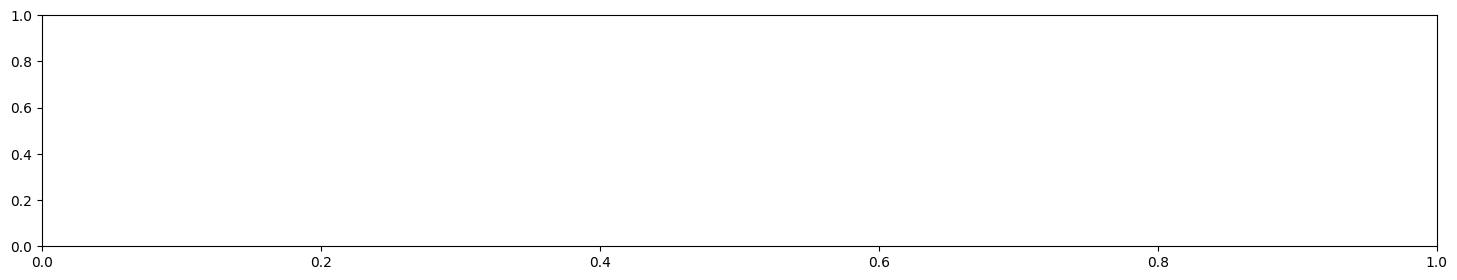

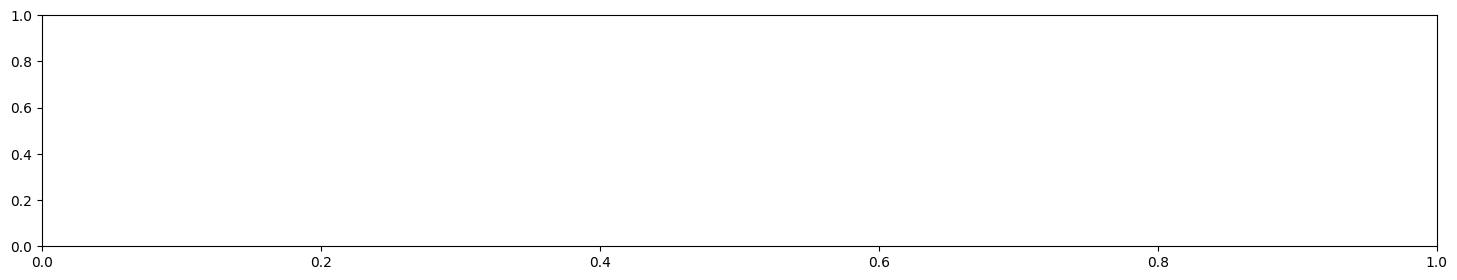

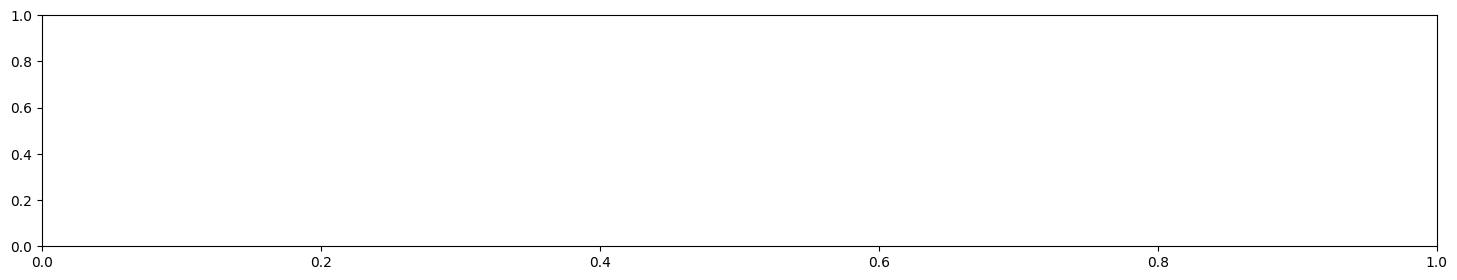

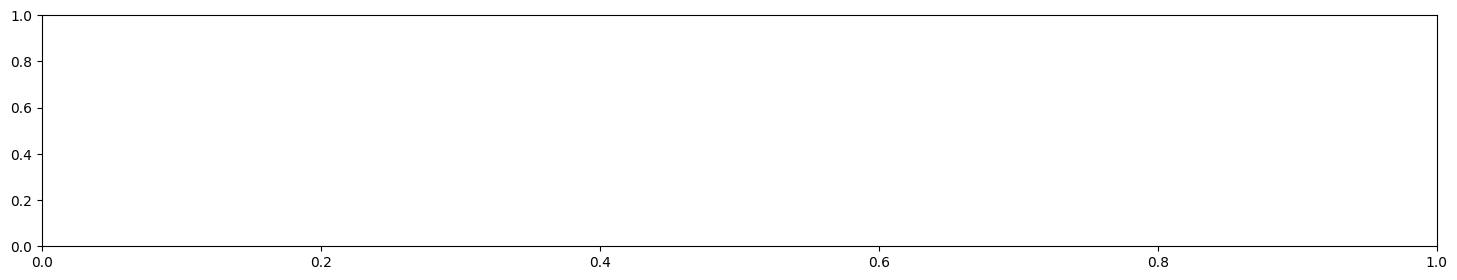

In [5]:
# Create treatment failure plots for all strategies
# Note: due to incomplete batch runs, some strategies may not have data or have incomplete data
# Incomplete data will result in a ValueError when plotting due to a dimension mismatch
for strategy in strategies:
    try:
        data, months = aggregate_monthlysitedata(DATA_SOURCE, strategy, 1)
    except TypeError as e:
        print(e)
        continue
    except FileNotFoundError as e:
        print(e)
        continue
    try:
        fig, ax = plot_strategy_treatment_failure(data, months, strategy.replace("_", " ").title())
    except ValueError as e:
        print(e)
        plt.close(fig)
        continue
    plt.savefig(f"{strategy}.png")
    plt.close(fig)

Aggregating data for strategy status_quo with 11 files
Aggregating data for /home/james/Desktop/output_old/rwanda_status_quo_1_monthly_data_0.db
Aggregating data for /home/james/Desktop/output_old/rwanda_status_quo_2_monthly_data_0.db
Aggregating data for /home/james/Desktop/output_old/rwanda_status_quo_4_monthly_data_0.db
Aggregating data for /home/james/Desktop/output_old/rwanda_status_quo_6_monthly_data_0.db
Aggregating data for /home/james/Desktop/output_old/rwanda_status_quo_7_monthly_data_0.db
Aggregating data for /home/james/Desktop/output_old/rwanda_status_quo_10_monthly_data_0.db
Aggregating data for /home/james/Desktop/output_old/rwanda_status_quo_9_monthly_data_0.db
Aggregating data for /home/james/Desktop/output_old/rwanda_status_quo_8_monthly_data_0.db
Aggregating data for /home/james/Desktop/output_old/rwanda_status_quo_0_monthly_data_0.db
Aggregating data for /home/james/Desktop/output_old/rwanda_status_quo_5_monthly_data_0.db
Aggregating data for /home/james/Desktop/out

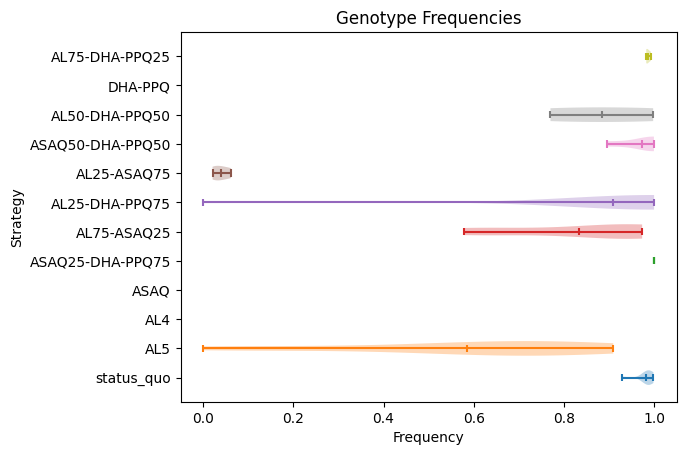

In [6]:
# Create a violin plot for a given genotype based on the row in agg_fqy
fig, ax = plt.subplots()
for i, strategy in enumerate(strategies):
    try:
        agg_fqy = aggregate_resistant_genome_frequencies(DATA_SOURCE, strategy)
    except TypeError as e:
        print(e)
        continue
    except FileNotFoundError as e:
        print(e)
        continue
    except ValueError as e:
        print(e)
        continue
    except IndexError as e:
        print(e)
        continue
    try:
        ax.violinplot(agg_fqy, positions=[i], showmeans=True, orientation='horizontal')
    except Exception as e:
        print(e)
        print(f"Error plotting {strategy}")
        continue
ax.set_title("Genotype Frequencies")
ax.set_xlabel("Frequency")
ax.set_ylabel("Strategy")
ax.set_yticks(range(len(strategies)))
ax.set_yticklabels(strategies)
plt.savefig("genotype_frequencies_violins.png")
plt.show()